# Markov Reviews Implemented: Removing Antiobiotic Exposed Participants

# TAXA LEVEL

In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.colors as pltcolors
from matplotlib.patches import Ellipse
from matplotlib import animation
import scipy as sp
import scipy.stats as stats
from scipy.cluster import hierarchy
import pykov
import rpy2
import string
import random
import time
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from IPython.display import HTML
from collections import defaultdict
from copy import deepcopy
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
def prettify_ax(ax):
    """
    Nifty function we can use to make our axes more pleasant to look at
    """
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    """
    Shortcut to make and 'prettify' a simple figure with 1 axis
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

COLORS = ['#FF9600', '#00A200', '#3359D4', '#A71865']
COLORS2 = ['#696969','#A00000']

In [28]:
ANTIBIOTIC_EXPOSED = ['1416.1052.2', '1416.1052.3', '1443.1076.2', '1443.1076.3', '1485.1102.1', '1485.1102.2', '1510.1125.1', '1510.1125.2', '1511.1126.1', '1511.1126.2', '1513.1128.1', '1513.1128.2']

In [46]:
# read in data
rawotu = pd.read_csv('data/updated_abundace_table.txt', sep='\t', index_col=0)
#weak_trans_idx = pd.read_csv('data/WeakTransitioningIdx.csv', index_col=0).values[:,0] #file written below
#fracotu = rawotu.drop(weak_trans_idx)
fracotu = deepcopy(rawotu)
oldshape = fracotu.shape
fracotu = fracotu.drop(ANTIBIOTIC_EXPOSED)
newshape = fracotu.shape
print oldshape[0]-newshape[0], "SAMPLES DROPPED FOR ANTIBIOTIC EXPOSURE"
print newshape
fracotu.head()

12 SAMPLES DROPPED FOR ANTIBIOTIC EXPOSURE
(304, 279)


,Lactobacillaceae Lactobacillus iners,Bifidobacteriaceae Gardnerella vaginalis,Lactobacillaceae Lactobacillus crispatus,Lachnospiraceae Candidatus_Lachnocurva vaginae_(BVAB1),Veillonellaceae Megasphaera sp_DNF00751,Prevotellaceae Prevotella amnii,Prevotellaceae Prevotella sp,Leptotrichiaceae Sneathia amnii,Prevotellaceae Prevotella bivia,Coriobacteriaceae Atopobium vaginae,...,Eubacteriaceae Eubacterium sp,Comamonadaceae Variovorax sp,Corynebacteriaceae Corynebacterium massiliense,Lachnospiraceae Anaerostipes hadrus,Peptostreptococcaceae Paeniclostridium sp,Sutterellaceae Sutterella wadsworthensis,Erysipelotrichaceae Clostridium_XVIII sp,Lachnospiraceae Faecalimonas umbilicata,Acidaminococcaceae Acidaminococcus sp,Bacteroidaceae Bacteroides sp
Sample_ID,,,,,,,,,,,,,,,,,,,,,
0001.003.1,0.000520,0.690689,0.000000,0.000104,0.0,0.0,0.0,0.0,0.006097,0.204370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.2,0.999572,0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.3,0.998146,0.000501,0.000111,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.4,0.999695,0.000305,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.5,0.760513,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# make hash table from id number to sample visits
ids = defaultdict(list)
for i in fracotu.index.values:
    a,b,c = i.split('.')
    ids[a+'.'+b].append(int(c))
for k in ids.keys():
    ids[k] = sorted(ids[k])
    nonadjacents, adjflag = [], False #remove non-adjacent timepoints
    for i in range(0,len(ids[k])-1):
        if ids[k][i]+1==ids[k][i+1]:
            adjflag = True
        else:
            if not adjflag:
                nonadjacents.append(i)
            if i==len(ids[k])-2:
                nonadjacents.append(i+1)
            adjflag = False
    for idx in sorted(nonadjacents, reverse=True):
        ids[k].pop(idx)
    if len(ids[k]) in [0,1]: #if no longitudinals, drop sample
        ids.pop(k)
idslist = sorted([k+'.'+str(e) for k in ids for e in ids[k]])
print "There are", len(ids), "patients with", len(idslist), "total samples; with timepoints listed below:"
dict(ids)

There are 82 patients with 304 total samples; with timepoints listed below:


{'0001.003': [1, 2, 3, 4, 5, 6],
 '0008.007': [3, 4, 5, 6],
 '0018.017': [3, 4, 5, 6],
 '0021.023': [5, 6, 7],
 '0029.043': [2, 3, 4],
 '0032.033': [1, 2, 4, 5, 6],
 '0036.028': [3, 4, 5, 6],
 '0041.030': [3, 4],
 '0044.034': [1, 2, 3, 4, 5],
 '0047.038': [3, 4, 5],
 '0051.064': [5, 6],
 '0055.051': [1, 2, 3, 4, 5, 6, 7],
 '0058.068': [1, 2, 3, 4],
 '0061.057': [2, 3, 4],
 '0067.062': [1, 2, 3, 4, 5, 6],
 '0068.050': [1, 2, 3, 4, 5, 6],
 '0079.069': [1, 2, 3, 4, 5, 6, 7],
 '0085.075': [1, 2, 3, 4, 5, 6],
 '0090.080': [1, 2, 3, 4, 5, 6, 7],
 '0094.086': [1, 2, 3, 5, 6, 7, 8],
 '0095.084': [2, 3],
 '0098.098': [1, 2, 3, 4],
 '0100.083': [1, 2, 3, 4],
 '0101.088': [1, 2, 3, 4, 5, 6],
 '0106.082': [2, 3],
 '0121.101': [1, 2, 3],
 '0123.103': [4, 5],
 '0135.111': [2, 3, 4, 5, 6],
 '0136.112': [1, 2, 3, 4, 5, 6],
 '0138.113': [1, 2, 4, 5],
 '0139.114': [1, 2, 3],
 '0154.119': [2, 3, 4],
 '0158.129': [1, 2, 3, 4, 5, 6],
 '0180.142': [1, 2, 5, 6, 7, 8],
 '0203.151': [1, 2, 3, 4],
 '0218.162': 

In [48]:
# filter fracotu by longitudinal samples
fracotu = fracotu.loc[idslist,:]

# merge crispatus and gardnerella species
sp_tomerge = [a for a in fracotu.columns if ((a.split()[0]=='Lactobacillaceae')&(a.split()[-1]!='iners'))]
fracotu['Lactobacillaceae Lactobacillus non_iners'] = fracotu[sp_tomerge].sum(1)
fracotu = fracotu.drop(sp_tomerge, 1)
sp_tomerge = [a for a in fracotu.columns if (a.split()[1]=='Gardnerella')]
fracotu['Bifidobacteriaceae Gardnerella'] = fracotu[sp_tomerge].sum(1)
fracotu = fracotu.drop(sp_tomerge, 1)
fracotu = fracotu.loc[:,fracotu.sum(0).sort_values(ascending=False).index]
print fracotu.shape
fracotu.head()

(304, 270)


,Lactobacillaceae Lactobacillus iners,Bifidobacteriaceae Gardnerella,Lactobacillaceae Lactobacillus non_iners,Lachnospiraceae Candidatus_Lachnocurva vaginae_(BVAB1),Veillonellaceae Megasphaera sp_DNF00751,Prevotellaceae Prevotella amnii,Prevotellaceae Prevotella sp,Leptotrichiaceae Sneathia amnii,Coriobacteriaceae Atopobium vaginae,Prevotellaceae Prevotella bivia,...,Lachnospiraceae Anaerostipes hadrus,Peptostreptococcaceae Paeniclostridium sp,Sutterellaceae Sutterella wadsworthensis,Microbacteriaceae Microbacterium lacticum,Comamonadaceae Comamonas sp,Erysipelotrichaceae Clostridium_XVIII sp,Lachnospiraceae Faecalimonas umbilicata,Acidaminococcaceae Acidaminococcus sp,Bacteroidaceae Bacteroides sp,Lachnospiraceae Catonella sp
Sample_ID,,,,,,,,,,,,,,,,,,,,,
0001.003.1,0.000520,0.690845,0.000000,0.000104,0.0,0.0,0.0,0.0,0.204370,0.006097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.2,0.999572,0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.3,0.998146,0.000501,0.000111,0.000000,0.0,0.0,0.0,0.0,0.000074,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.4,0.999695,0.000305,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001.003.5,0.760513,0.000000,0.238533,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
##### calculate dominance for each sample
Lcrisp, Liners, Gvag = 'Lactobacillaceae Lactobacillus non_iners', 'Lactobacillaceae Lactobacillus iners', 'Bifidobacteriaceae Gardnerella'
domtaxa_abund = {Lcrisp:[], Liners:[], Gvag:[], 'other':[]}
for colnum in range(fracotu.T.shape[1]):
    col_curr = fracotu.T.iloc[:, colnum].sort_values(ascending=False)
    dom_curr, dom_abund = col_curr.index.values[0], col_curr[0]
    if dom_curr in [Lcrisp, Liners, Gvag]:
        domtaxa_abund[dom_curr].append(col_curr[0]) 
    else:
        domtaxa_abund['other'].append(col_curr[0])

cutoffs = {Lcrisp:0, Liners:0, Gvag:0, 'other':0} #determine cutoffs
for species in [Lcrisp, Liners, Gvag, 'other']:
    abundances = np.array(domtaxa_abund[species])
    cutoffs[species] = np.percentile(abundances, 5)
    
weak_trans_idx = []
for colnum in range(fracotu.T.shape[1]):
    col_curr = fracotu.T.iloc[:, colnum].sort_values(ascending=False)
    dom_curr, dom_abund = col_curr.index.values[0], col_curr[0]
    if dom_curr in [Lcrisp, Liners, Gvag] and dom_abund<cutoffs[dom_curr]:
        weak_trans_idx.append(col_curr.name)
    elif dom_abund<cutoffs['other']:
        weak_trans_idx.append(col_curr.name)
##pd.DataFrame(weak_trans_idx).to_csv('data/WeakTransitioningIdx.csv') #file called above

## Assign CTs

In [50]:
# assign a CT to each sample
cts = []
Lcrisp, Liners, Gvag = 'Lactobacillaceae Lactobacillus non_iners', 'Lactobacillaceae Lactobacillus iners', 'Bifidobacteriaceae Gardnerella'
domtaxa_abund = {Lcrisp:[], Liners:[], Gvag:[], 'other':[]}
for colnum in range(fracotu.T.shape[1]):
    col_curr = fracotu.T.iloc[:, colnum].sort_values(ascending=False)
    dom_curr, dom_bool = col_curr.index.values[0], col_curr[0]>0.5
    if dom_curr in [Lcrisp, Liners, Gvag]:
        domtaxa_abund[dom_curr].append(col_curr[0]) 
    else:
        domtaxa_abund['other'].append(col_curr[0]) 
    if dom_curr == Lcrisp and dom_bool:
        cts.append(1)
    elif dom_curr == Liners:
        cts.append(2)
    elif dom_curr == Gvag:
        cts.append(3)
    else:
        cts.append(4)
ct_df = pd.DataFrame(data={'CT':cts},index=fracotu.T.columns.values)
ct_df.head()

,CT
0001.003.1,3
0001.003.2,2
0001.003.3,2
0001.003.4,2
0001.003.5,2


In [51]:
# create dictionaries with patient id keys and timepoint/ct values
time_ct_dict = {} #values are tuples of timepoint and ct
ct_dict = {} #values are cts
for k in ids.keys():
    curr_cts = []
    curr_timects = []
    for t in ids[k]:
        idcurr = k+'.'+str(t)
        tup = (t, ct_df.loc[idcurr, 'CT'])
        curr_timects.append(tup)
        curr_cts.append(tup[1])
    time_ct_dict[k] = curr_timects
    ct_dict[k] = curr_cts
ct_dict

{'0001.003': [3, 2, 2, 2, 2, 2],
 '0008.007': [2, 2, 2, 4],
 '0018.017': [4, 4, 4, 4],
 '0021.023': [4, 4, 4],
 '0029.043': [4, 4, 4],
 '0032.033': [2, 4, 3, 2, 4],
 '0036.028': [3, 3, 4, 4],
 '0041.030': [2, 3],
 '0044.034': [2, 3, 3, 3, 4],
 '0047.038': [2, 2, 2],
 '0051.064': [4, 4],
 '0055.051': [1, 2, 1, 1, 3, 3, 4],
 '0058.068': [2, 2, 4, 3],
 '0061.057': [4, 4, 4],
 '0067.062': [3, 2, 3, 3, 1, 1],
 '0068.050': [2, 4, 2, 2, 2, 2],
 '0079.069': [4, 4, 4, 4, 2, 4, 3],
 '0085.075': [2, 4, 2, 2, 2, 3],
 '0090.080': [2, 2, 2, 3, 3, 4, 4],
 '0094.086': [2, 1, 2, 2, 2, 2, 2],
 '0095.084': [4, 1],
 '0098.098': [2, 2, 2, 2],
 '0100.083': [4, 4, 4, 4],
 '0101.088': [4, 3, 4, 3, 2, 2],
 '0106.082': [2, 3],
 '0121.101': [4, 4, 4],
 '0123.103': [4, 4],
 '0135.111': [1, 1, 4, 4, 4],
 '0136.112': [3, 4, 2, 3, 3, 4],
 '0138.113': [4, 2, 1, 2],
 '0139.114': [2, 2, 2],
 '0154.119': [3, 3, 4],
 '0158.129': [1, 1, 1, 1, 4, 2],
 '0180.142': [4, 2, 1, 2, 3, 2],
 '0203.151': [3, 3, 4, 3],
 '0218.162': 

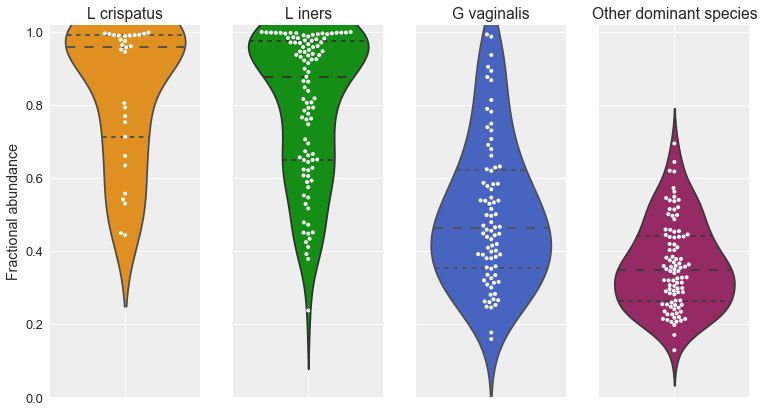

In [52]:
f, axarr = plt.subplots(1,4, figsize=(11,6))
sns.set(font_scale=1.3)
titles = ['L crispatus', 'L iners', 'G vaginalis', 'Other dominant species']
for e,ct in enumerate([Lcrisp, Liners, Gvag, 'other']):
    ax = axarr[e]
    sns.violinplot(domtaxa_abund[ct], orient='v', color=COLORS[e], inner='quartiles', ax=ax)
    sns.swarmplot(domtaxa_abund[ct], orient='v', color='white', size=4, ax=ax)
    ax.set_title(titles[e])
    ax.set_ylim([0,1.02])
    if e==0:
        ax.set_ylabel('Fractional abundance')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    prettify_ax(ax)
plt.tight_layout()
#plt.savefig('figures/dominant_species_abundances.pdf', bbox_inches='tight')
plt.show()

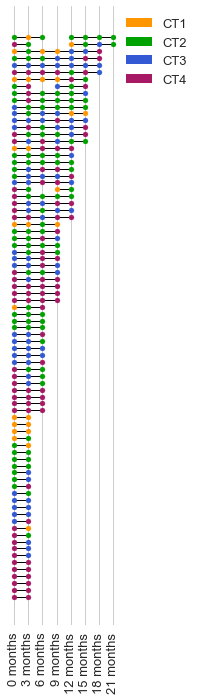

In [53]:
#plot sample collection times
ordered_k = sorted(ids.keys(), key=lambda k:(max(np.array(ids[k])-min(ids[k])+1),-ct_dict[k][0],-ct_dict[k][1]))
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
fig = plt.figure(figsize=(3,10))
ax = fig.add_subplot(111)
ax.set_yticks([])
#ax.grid('off')
sns.despine(left=True, bottom=True, right=True)
for y,k in enumerate(ordered_k):
    scaled = list(np.array(ids[k])-min(ids[k])+1)
    #ax.plot([min(scaled),max(scaled)], [y,y], linewidth=1, c='k', zorder=1)
    for e,t in enumerate(scaled):
        ax.scatter(t, y, c=COLORS[ct_dict[k][e]-1], s=25, zorder=2)
        if e!=0 and t==scaled[e-1]+1:
            ax.plot([t-1,t], [y,y], linewidth=1, c='k', zorder=1)
ax.set_xticks(range(1,9))
ax.set_xticklabels([str(e)+' months' for e in np.arange(0,22,3)],rotation=90)
recs = []
for i in range(4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=COLORS[i]))
ax.legend(recs,['CT1', 'CT2', 'CT3', 'CT4'], prop={'size':13}, bbox_to_anchor=(.95, 1))
plt.tight_layout()
#plt.savefig('figures/samplecollection.pdf', bbox_inches='tight')
plt.show()

## Create CT transition counts matrix

In [54]:
# create dictionary of ids that transition to a given ct based on starting ct
transitions = np.zeros((4,4)) #also keep track of number of transitions
cttrans_dict = defaultdict(list)
for k in ct_dict.keys():
    for i in range(len(ct_dict[k])-1):
        starttime, endtime = ids[k][i], ids[k][i+1]
        if endtime==starttime+1:
            startct, endct = ct_dict[k][i], ct_dict[k][i+1]
            transitions[startct-1][endct-1] += 1
            curr_trans = 'CT'+str(startct)+'_WR' if startct==endct else 'CT'+str(startct)+'_WNR'
            startid = k+'.'+str(starttime)
            cttrans_dict[curr_trans].append(startid)

In [55]:
# generate a ct transitions matrix and save as csv
transitions_df = pd.DataFrame(data=transitions, \
                              index=['From CT1', 'From CT2', 'From CT3', 'From CT4'], \
                              columns=['To CT1', 'To CT2', 'To CT3', 'To CT4'])
#transitions_df.to_csv('data/ct_transitions.csv')
print "There were", int(transitions.sum()), "total transitions observed in the dataset."
transitions_df

There were 218 total transitions observed in the dataset.


,To CT1,To CT2,To CT3,To CT4
From CT1,10.0,7.0,1.0,2.0
From CT2,4.0,44.0,13.0,10.0
From CT3,1.0,11.0,30.0,18.0
From CT4,1.0,14.0,16.0,36.0


# CT LEVEL

In [56]:
pykov.__version__

1.1

In [57]:
##### HELPERS #####

def normalize_probs(trans_mat):
    ''' normalize transition matrix to matrix of probabilities '''
    probs_mat = trans_mat/trans_mat.sum(axis=1, keepdims=True)
    return probs_mat

def probs2chain(probs_mat):
    ''' convert probabilities matrix to pykov chain '''
    probdict = {}
    for i in range(probs_mat.shape[0]):
        for j in range(probs_mat.shape[1]):
            if probs_mat.shape[0] == 2:
                k = ('CT'+str(2*i+1)+'/'+str(2*i+2), 'CT'+str(2*j+1)+'/'+str(2*j+2))
            else:
                k = ('CT'+str(i+1), 'CT'+str(j+1))
            v = probs_mat[i,j]
            probdict[k]=v
    return pykov.Chain(probdict)

def chain2steady(chain_in, shape=4, printbool=False):
    ''' determines and prints steady state distribution from pykov chain '''
    steadychain = chain_in.steady()
    steadylist = []
    for i in range(shape):
        ct = 'CT'+str(i+1)
        st = steadychain[ct]
        if printbool:
            print ct, ":", st
        steadylist.append(st)
    steadyarray = np.array(steadylist)
    return steadyarray

def chain2steps(chain_in):
    ''' determines a matrix of average cervicotype transition steps from pykov chain  '''
    steps_out = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            steps_out[i,j] = chain_in.mfpt_to('CT'+str(j+1))['CT'+str(i+1)]
    return steps_out

def steps2df(steps_in, saveascsv=False):
    ''' converts step matrix to pandas dataframe for easier visualization and exporting to csv '''
    df = pd.DataFrame(steps_in)
    df.index = ['From CT' + str(i+1) for i in range(4)]
    df.columns = ['To CT' + str(i+1) for i in range(4)]
    return df

def draw_probs(alpha_mat):
    ''' draw a probability matrix from a matrix of posterior dirichlet parameter alpha values '''
    probs_mat = np.zeros((alpha_mat.shape[0], alpha_mat.shape[1]))
    for i in range(alpha_mat.shape[0]):
        curr_alpha = posterior_alpha[i,:]
        curr_probs = np.random.dirichlet(curr_alpha)
        probs_mat[i,:] = curr_probs
    return probs_mat

def draw_n_steps(n=1000):
    ''' draw probability matrix, convert to chain, calculate step matrix, convert to pandas dataframe '''
    stepdraws = []
    steadies = []
    for i in range(n):
        probdraw = draw_probs(posterior_alpha)
        chaindraw = probs2chain(probdraw)
        stepdraw = chain2steps(chaindraw)
        stepdraws.append(stepdraw)
        steadies.append(chaindraw.steady())
    return stepdraws, steadies

def mean_confidence_interval(data, confidence=0.95):
    ''' calculate confidence interval and mean of list of data arrays '''
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

def vector2list(vec):
    ''' convert pykov vector to ordered list '''
    lst = [vec['CT1'], vec['CT2'], vec['CT3'], vec['CT4']]
    return lst

def subsample(transitions):
    ''' subsample with replacement from transition counts for bootstrap '''
    num_transitions = np.sum(transitions)
    trans_probs = transitions / num_transitions
    startct_probs = np.sum(trans_probs, axis=1)
    subsample_arr = np.zeros((4,4))
    for transition in range(int(num_transitions)):
        startct = np.random.choice(4, p=startct_probs)
        nextct_probs = trans_probs[startct,:]/np.sum(trans_probs[startct,:])
        endct = np.random.choice(4, p=nextct_probs)
        subsample_arr[startct, endct] += 1
    return subsample_arr

def bootstrap(transitions, num_samples=10000):
    ''' perform bootstrapping, returns list of stationary distributions '''
    samples = []
    for iteration in range(num_samples):
        transitions_curr = subsample(transitions)
        probs_curr = normalize_probs(transitions_curr)
        chain_curr = probs2chain(probs_curr)
        steady_curr = chain2steady(chain_curr, printbool=False)
        samples.append(steady_curr)
    return samples

def kl_divergence(p,q):
    ''' calculates the kl divergence between two probability vectors '''
    epsilon = 0.00001
    p2 = np.array(deepcopy(p))+epsilon
    q2 = np.array(deepcopy(q))+epsilon
    kl = np.sum(p2*np.log(p2/q2))
    return kl

In [58]:
sns.set(font_scale=1.5)

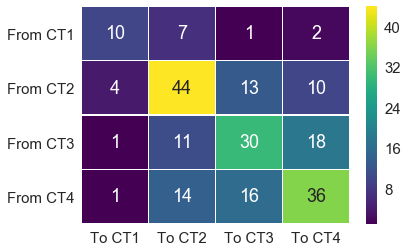

In [59]:
# determine ct transitions
sns.heatmap(steps2df(transitions), annot=True, cmap='viridis', linewidths=0.5)
plt.savefig('figures/transitions_table_AbxExpRemoved.pdf', bbox_inches='tight')
plt.show()

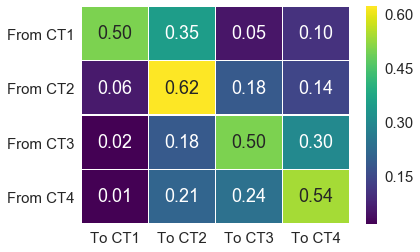

In [60]:
# convert transitions matrix to probability matrix
probs = normalize_probs(transitions)
sns.heatmap(steps2df(probs), annot=True, cmap='viridis', linewidths=0.5, fmt='.2f')
plt.savefig('figures/probs_table_AbxExpRemoved.pdf', bbox_inches='tight')
plt.show()